## Vectorization

In [206]:
import pandas as pd

In [207]:
corpus = pd.read_csv('finance_tweets_train.csv').drop(columns = ['Unnamed: 0'])
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9534 entries, 0 to 9533
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9534 non-null   object
dtypes: object(1)
memory usage: 74.6+ KB


In [208]:
Train_df = pd.read_csv('sent_train.csv')

In [209]:
#Train_df['label'].drop(drop_list).reset_index()

In [210]:
from sklearn.feature_extraction.text import CountVectorizer

In [211]:
vec = CountVectorizer()
X_train = vec.fit_transform(corpus['text'])
countvec_df = pd.DataFrame(X_train.toarray(), columns=vec.get_feature_names())

In [212]:
y_tar = Train_df['label'].drop(drop_list).reset_index().drop(columns =['index'])
z = pd.concat([countvec_df, y_tar],1)

In [213]:
z.groupby('label').sum().T.sort_values(by = 2, ascending = False)

label,0,1,2
stock,210,367,681
result,30,31,321
say,64,78,318
report,54,57,308
new,32,96,287
...,...,...,...
squeak,0,1,0
converter,0,1,0
convert,0,1,0
icpt,0,5,0


## Topic Modeling

In [214]:
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import numpy as np

In [215]:
topic_model = NMF(n_components = 3)
topic_model.fit(X_train)

NMF(n_components=3)

In [216]:
H = topic_model.transform(X_train)
W = topic_model.components_

In [217]:
W

array([[6.07037767e-04, 4.07943907e-03, 4.16696067e-03, ...,
        0.00000000e+00, 2.98041035e-05, 5.55114619e-05],
       [4.09968331e-05, 8.62464078e-05, 0.00000000e+00, ...,
        3.55295549e-03, 1.94810146e-04, 8.44663201e-05],
       [1.13564220e-04, 2.87618252e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.53883787e-04, 1.23665274e-04]])

In [218]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vec.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['get', 'share', 'cut', 'china', 'new', 'read', 'good', 'oil', 'open', 'deal', 'news', 'say', 'gain', 'energy', 'economy', 'raise', 'high', 'trade', 'buy', 'target', 'price', 'update', 'marketscreener', 'market', 'stock']


THE TOP 10 WORDS FOR TOPIC #1
['seek', 'economy', 'analyst', 'group', 'preview', 'update', 'read', 'fourth', 'get', 'say', 'new', 'year', 'financial', 'quarter', 'edited', 'ceo', 'edit', 'report', 'gmt', 'conference', 'presentation', 'transcript', 'result', 'call', 'earnings']


THE TOP 10 WORDS FOR TOPIC #2
['oil', 'expectation', 'profit', 'global', 'investment', 'factset', 'total', 'cent', 'group', 'report', 'forecast', 'sale', 'growth', 'rev', 'estimate', 'consensus', 'year', 'analyst', 'say', 'share', 'new', 'miss', 'eps', 'revenue', 'beat']




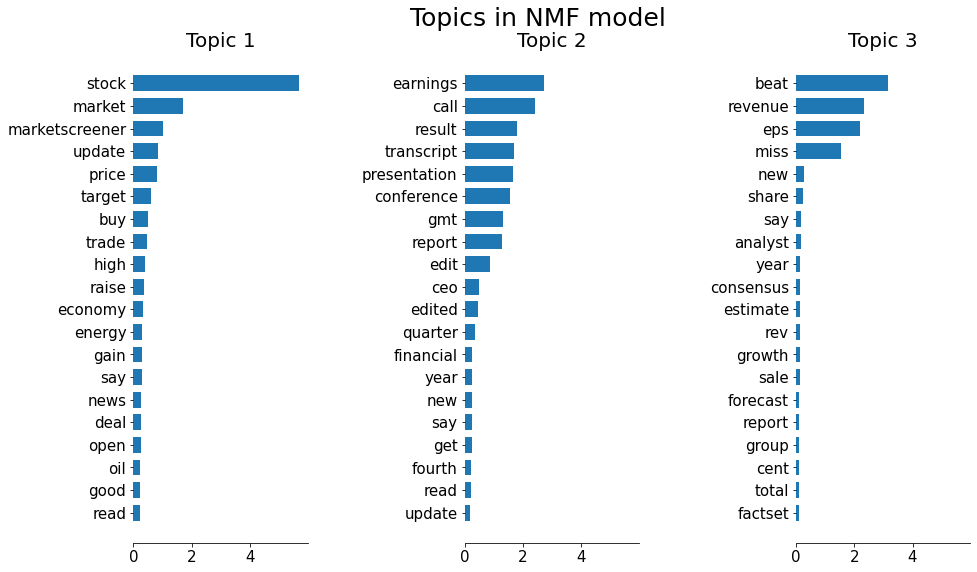

In [219]:
import matplotlib.pyplot as plt
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vec.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

In [220]:
topic_name_dict = {0: 'Stocks', 1: 'Earnings Report', 2: 'Company/Stock Evaluation'}
import seaborn as sns
def tweet_topbreakdown(locator):

    print(corpus.loc[locator].text)
    int_index = corpus.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
    plt.title("Distribution of topics for tweet no. " + str(locator))
    plt.show()

    return topic_breakdown

bynd jpmorgan reel expectation meat


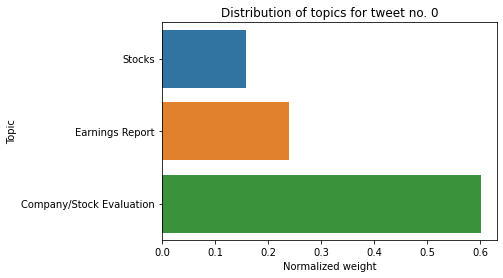

gtt cowen cut market perform


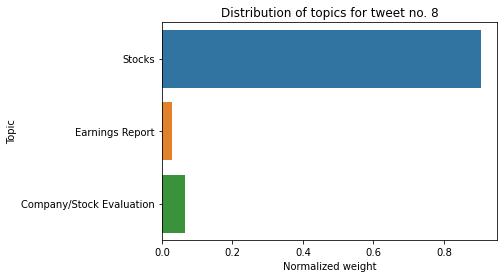

alphabet facebook price target cut barclays weak ad outlook


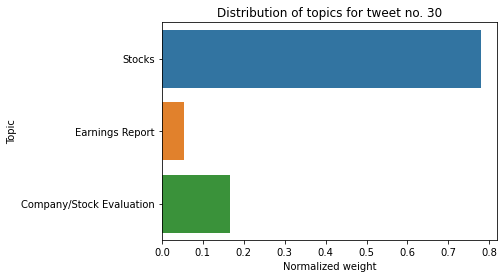

canada goose stock price target cut cfra


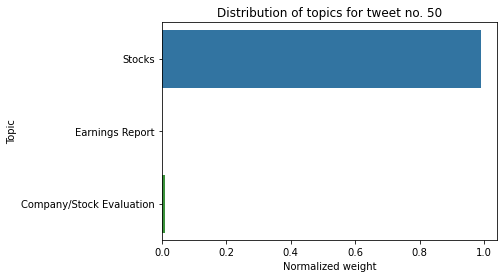

napco security stock price target cut imperial capital


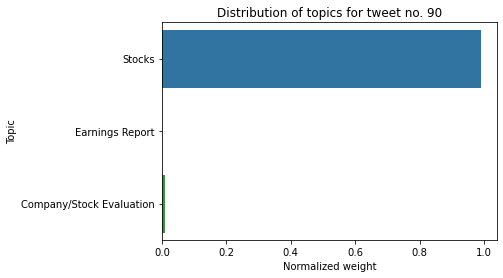

In [221]:
tweet_loc_list = [0,8, 30, 50, 90]
g = list(map(tweet_topbreakdown, tweet_loc_list))

In [222]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [223]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

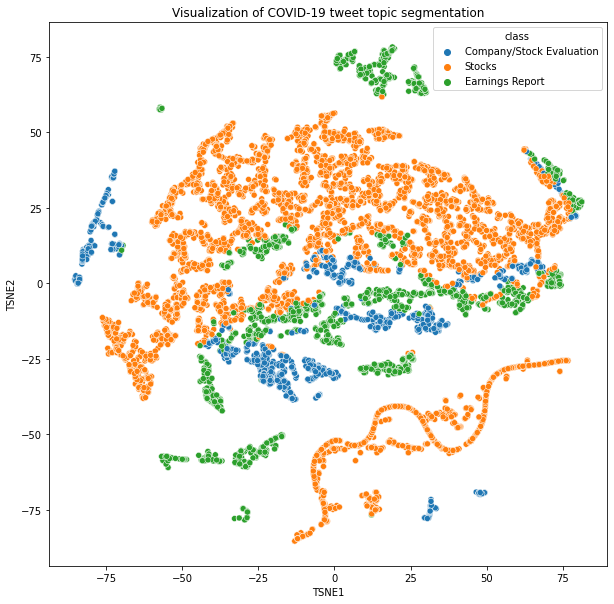

In [224]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of COVID-19 tweet topic segmentation')
plt.show()